<a href="https://colab.research.google.com/github/FaresSouissi/BTYDplus/blob/master/CLV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
pip install btyd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.4/605.4 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.2/590.2 KB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 KB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.8 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.5
    Uninstalling autograd-1.5:
      Successfully uninstalled autograd-1.5
  Attempting uninstall: pymc
    Found existing installation: pymc 5.1.2
    Uninstalling pymc-5.1.2:
      Successfully uninstalled pymc-5.1.2


In [ ]:
df = pd.read_csv("mydata.csv")

df.head()

,InvoiceNo,volume,value,customer_id,Country,date
0,536365,40,139.12,17850.0,United Kingdom,2010-01-12
1,536366,12,22.20,17850.0,United Kingdom,2010-01-12
2,536367,83,278.73,13047.0,United Kingdom,2010-01-12
3,536368,15,70.05,13047.0,United Kingdom,2010-01-12
4,536369,3,17.85,13047.0,United Kingdom,2010-01-12


In [ ]:
from btyd.utils import summary_data_from_transaction_data

df_parsed = summary_data_from_transaction_data(
    df, 
    customer_id_col="customer_id", 
    datetime_col="date",
    monetary_value_col="value",
)
df_parsed = df_parsed[df_parsed["frequency"] != 0]

In [ ]:
df_parsed

,frequency,recency,T,monetary_value
customer_id,,,,
12347.0,4.0,421.0,516.0,457.125000
12352.0,1.0,67.0,341.0,311.730000
12358.0,1.0,117.0,120.0,484.860000
12359.0,3.0,292.0,301.0,1165.243333
12362.0,4.0,213.0,243.0,414.462500
...,...,...,...,...
18263.0,1.0,184.0,340.0,503.800000
18272.0,3.0,156.0,159.0,369.246667
18273.0,1.0,64.0,215.0,51.000000


In [ ]:
from lifetimes import BetaGeoFitter

model = BetaGeoFitter()
model.fit(
    frequency=df_parsed["frequency"], 
    recency=df_parsed["recency"], 
    T=df_parsed["T"]
)
print(model.summary)

               coef   se(coef)  lower 95% bound  upper 95% bound
r      3.377490e+00   0.217809         2.950585         3.804395
alpha  3.547851e+02  23.921298       307.899362       401.670852
a      9.096401e-08   0.000025        -0.000049         0.000049
b      7.887156e-07   0.000215        -0.000421         0.000422


<Axes: title={'center': 'mean: 0.010, var: 0.000'}, xlabel='Transaction Rate', ylabel='Density'>

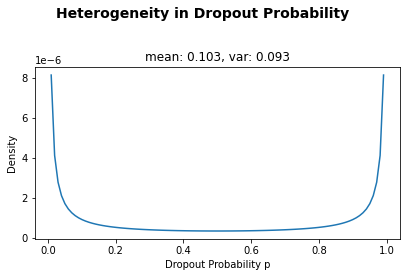

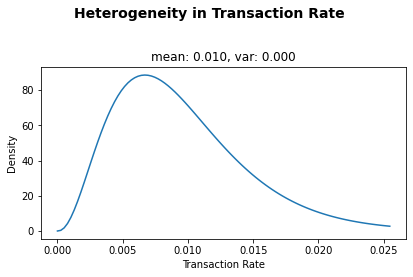

In [ ]:
from btyd import plotting

plotting.plot_dropout_rate_heterogeneity(model)
plotting.plot_transaction_rate_heterogeneity(model)

<Axes: title={'center': 'Expected Number of Future Purchases for 7 Units of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

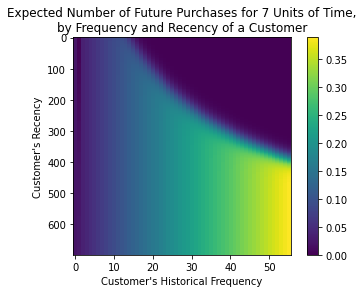

In [ ]:
plotting.plot_frequency_recency_matrix(model, T=7)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

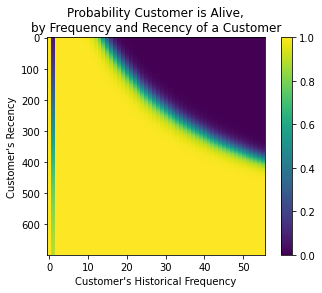

In [ ]:
plotting.plot_probability_alive_matrix(model)

In [ ]:
model.predict(
    t=100,
    frequency=3.5,
    recency=450,
    T=500,
)

0.8045869559990909

In [ ]:
df_parsed[["monetary_value", "frequency"]].corr()

,monetary_value,frequency
monetary_value,1.000000,0.130355
frequency,0.130355,1.000000


In [ ]:
df_parsed.dtypes

frequency         float64
recency           float64
T                 float64
monetary_value    float64
dtype: object

In [ ]:

df_parsed = df_parsed[df_parsed['monetary_value'] > 0]

In [ ]:
from btyd import GammaGammaFitter


gg_model = GammaGammaFitter()
gg_model.fit(
    frequency=df_parsed["frequency"],
    monetary_value=df_parsed["monetary_value"]
)

<btyd.GammaGammaFitter: fitted with 1532 subjects, p: 1.3126846013400655, q: 3.504573027978058, v: 748.1592682837288>

In [ ]:
gg_model.conditional_expected_average_profit(
    frequency=df_parsed["frequency"],
    monetary_value=df_parsed["monetary_value"]
)

customer_id
12347.0    436.132188
12352.0    364.476401
12358.0    424.012619
12359.0    864.692033
12362.0    407.247516
              ...    
18263.0    430.525737
18272.0    378.139299
18273.0    274.816155
18282.0    216.715478
18283.0    240.202651
Length: 1532, dtype: float64

In [ ]:
gg_model.customer_lifetime_value(
    transaction_prediction_model=model,
    frequency=df_parsed["frequency"],
    recency=df_parsed["recency"],
    T=df_parsed["T"],
    monetary_value=df_parsed["monetary_value"],
    time=1000,
    discount_rate=0.01,
)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1527   NaN
1528   NaN
1529   NaN
1530   NaN
1531   NaN
Name: clv, Length: 1532, dtype: float64

In [1]:
df_parsed

NameError: ignored